# Evaluation Of Duet Benchmarking Results from Distributed Database "Cassandra"

### Imports

In [476]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import os
from pathlib import Path

### Set Configuration 

In [477]:
setup1=False
aa = False

workloadLoad = "Workload C: 100% Insert"
workloadRun = "Workload C: 100% Read"
phase = "Run"



versionA = "A: Cassandra 4.0.4"
versionB = "B: Cassandra 4.0.4" if aa else "B: Cassandra 3.0.27"

### Import Benchmarking Measurements as csv file and create Pandas Dataframe for further Analysis

In [478]:
if(setup1): 
    part1=""
    part2="1.25mCops_4t"
else: 
    part1="international"
    part2="1mAops_4t"
    
cwd = Path.cwd()
filepath = os.path.join(cwd, "Results", part1, part2,"AA" if aa else "AB", "run_measurements1.csv")

df = pd.read_csv(filepath)


### Insert latencies in ms into the measurement table

In [479]:
df["latency_ms"] = (df["received"]- df["sent"])/1000000

In [480]:
df["sent_ms"] = df["sent"].div(1000000)
df["received_ms"] = df["received"].div(1000000)
df = df.sort_values(by="sent", ascending=True)


### Restructure Timeline

In [481]:
firstSent = df["sent"].min()
df["sent_sec"] = (df["sent"] - firstSent)/1000000/1000

### Return benchmark run time (First request send to last response received)

In [482]:
totalTime = df["sent"].max() - df["sent"].min()
print(totalTime/1000000/1000, "seconds", "or", totalTime/1000000/1000/60, "m") 


881.267953845 seconds or 14.687799230749999 m


### Prune Measurements and print new run time for pruned benchmark (Remove first and last 100 seconds)

In [483]:
# < (totalTime/1000000/1000) <

if setup1: 
    endTime=800
else: 
    endTime=600
    
dfPruned = df.loc[(df["sent_sec"] > 200) & (df["sent_sec"] < endTime)]

In [484]:
totalTime = dfPruned["sent"].max() - dfPruned["sent"].min()
print("Pruned time:\n",totalTime/1000000/1000, "seconds", "or", totalTime/1000000/1000/60, "minutes") 

Pruned time:
 399.998577277 seconds or 6.666642954616666 minutes


### Create subsets of dataframe (for Version A and B, and for each worker for Version A and B) 

In [485]:
dfARaw=df.loc[(df["workerId"] == "w1-vA") | (df["workerId"] == "w2-vA") | (df["workerId"] == "w3-vA")]
dfBRaw=df.loc[(df["workerId"] == "w1-vB") | (df["workerId"] == "w2-vB") | (df["workerId"] == "w3-vB")]
dfA1 = dfPruned.loc[(dfPruned["workerId"] == "w1-vA")]
dfA2 = dfPruned.loc[(dfPruned["workerId"] == "w2-vA")]
dfA3 = dfPruned.loc[(dfPruned["workerId"] == "w3-vA")]
dfB1 = dfPruned.loc[(dfPruned["workerId"] == "w1-vB")]
dfB2 = dfPruned.loc[(dfPruned["workerId"] == "w2-vB")]
dfB3 = dfPruned.loc[(dfPruned["workerId"] == "w3-vB")]
dfA = dfPruned.loc[(dfPruned["workerId"] == "w1-vA") | (dfPruned["workerId"] == "w2-vA") | (dfPruned["workerId"] == "w3-vA")]
dfB = dfPruned.loc[(dfPruned["workerId"] == "w1-vB") | (dfPruned["workerId"] == "w2-vB") | (dfPruned["workerId"] == "w3-vB")]
dfARaw = df.loc[(df["workerId"] == "w1-vA") | (df["workerId"] == "w2-vA") | (df["workerId"] == "w3-vA")]
dfBRaw = df.loc[(df["workerId"] == "w1-vB") | (df["workerId"] == "w2-vB") | (df["workerId"] == "w3-vB")]
if not setup1: 
    dfR1 = df.loc[(df["target-region"] == "europe-west1")]
    dfR2 = df.loc[(df["target-region"] == "europe-west2")]
    dfR3 = df.loc[(df["target-region"] == "europe-west3")]

    dfAr1Raw=dfARaw.loc[(df["target-region"] == "europe-west1")]
    dfBr1Raw=dfBRaw.loc[(df["target-region"] == "europe-west1")]
    dfAr2Raw=dfARaw.loc[(df["target-region"] == "europe-west2")]
    dfBr2Raw=dfBRaw.loc[(df["target-region"] == "europe-west2")]
    dfAr3Raw=dfARaw.loc[(df["target-region"] == "europe-west3")]
    dfBr3Raw=dfBRaw.loc[(df["target-region"] == "europe-west3")]

    dfAUpdate = dfA.loc[(dfA["queryType"] == "UPDATE")]
    dfBUpdate = dfB.loc[(dfB["queryType"] == "UPDATE")]
    dfARead = dfA.loc[(dfA["queryType"] == "SELECT")]
    dfBRead = dfB.loc[(dfB["queryType"] == "SELECT")]

### Calculate Percentiles

In [486]:
ninetyA = dfA["latency_ms"].dropna().quantile([.9])
ninetynineA = dfA["latency_ms"].dropna().quantile([.99])
print("90% percentile versionA --> ", ninetyA, "\n99% percentile Version A --> ", ninetynineA)


90% percentile versionA -->  0.9    13.78355
Name: latency_ms, dtype: float64 
99% percentile Version A -->  0.99    144.419535
Name: latency_ms, dtype: float64


In [487]:
ninetyB = dfB["latency_ms"].dropna().quantile([.9])
ninetynineB = dfB["latency_ms"].dropna().quantile([.99])
print("90% percentile versionA --> ", ninetyB, "\n99% percentile Version A --> ", ninetynineB)

90% percentile versionA -->  0.9    4.815346
Name: latency_ms, dtype: float64 
99% percentile Version A -->  0.99    140.672537
Name: latency_ms, dtype: float64


### Some checks

#### Time difference in ms when first query was sent by worker-1 to Version A and B 

In [488]:

dfA2["sent"].min() - dfB2["sent"].min()

1234444

#### Time difference in ms when last query was sent by worker-1 to Version A and B 

In [489]:
dfA1["sent"].max() - dfB1["sent"].max() 


3246433

## Create Figures 

### Create Boxplots

In [490]:
sns.set_theme(style="darkgrid")
print(len(dfA))

453610


In [491]:
if setup1: 
    combined_dfs = pd.DataFrame({versionA: dfA['latency_ms'],
                                 versionB: dfB['latency_ms']})

    sns.set_style('white')
    sns.set_context('notebook', font_scale=2.0)

    box_plot = sns.boxplot(data=combined_dfs, color='white', showfliers=False, whis=1.5,palette="vlag").set_title("Setup 1: Read")




    ax = box_plot.axes
    ax.set_ylabel("Latency in ms")
    lines = ax.get_lines()

    categories = ax.get_xticks()

    for i in range(0,5):
        for cat in categories:

            y = round(lines[(i+cat*5)].get_ydata()[0],2) 

            ax.text(
                cat, 
                y, 
                f'{y}', 
                ha='center', 
                va='center', 
                fontweight='bold', 
                size=20,
                color='white',
                bbox=dict(facecolor='#445A64'))


    sns.despine()



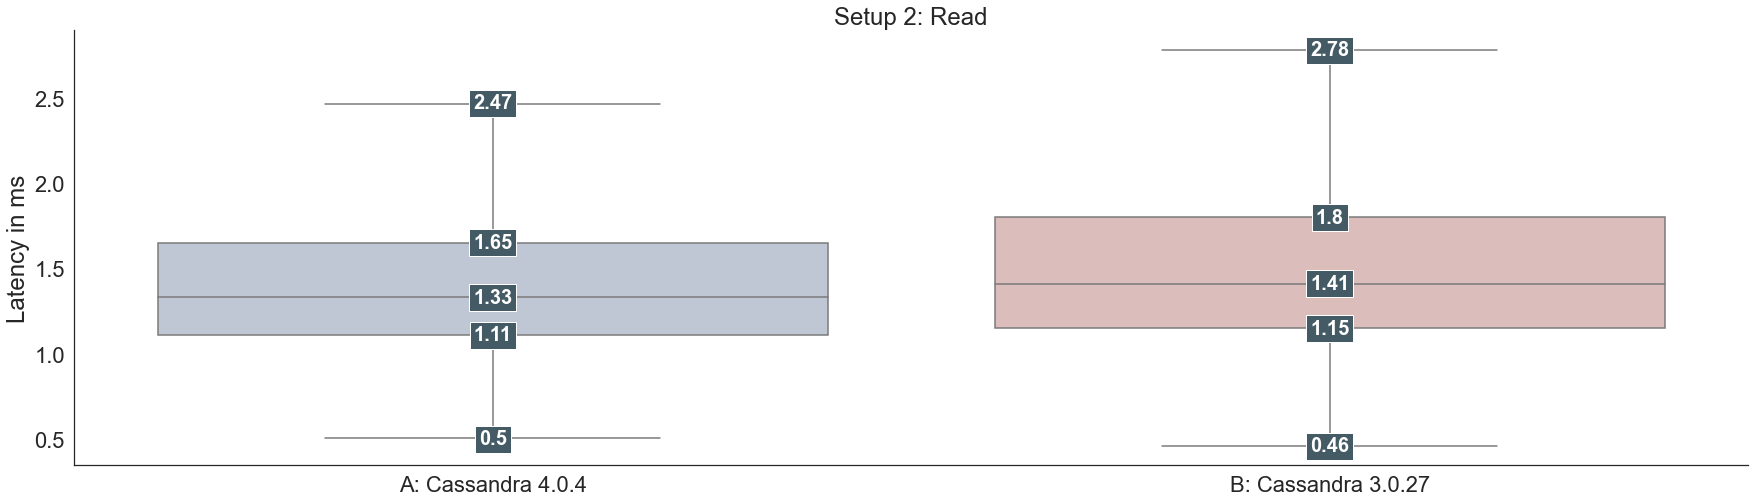

In [492]:
if not setup1: 
    combined_dfs = pd.DataFrame({versionA: dfAUpdate['latency_ms'],
                                 versionB: dfBUpdate['latency_ms']})

    sns.set_style('white')
    sns.set_context('notebook', font_scale=2.0)

    box_plot = sns.boxplot(data=combined_dfs, color='white', showfliers=False, whis=1.5,palette="vlag").set_title("Setup 2: Read")



    ax = box_plot.axes
    ax.set_ylabel("Latency in ms")
    lines = ax.get_lines()

    categories = ax.get_xticks()

    for i in range(0,5):
        for cat in categories:

            y = round(lines[(i+cat*5)].get_ydata()[0],2) 

            ax.text(
                cat, 
                y, 
                f'{y}', 
                ha='center', 
                va='center', 
                fontweight='bold', 
                size=20,
                color='white',
                bbox=dict(facecolor='#445A64'))


    sns.despine()

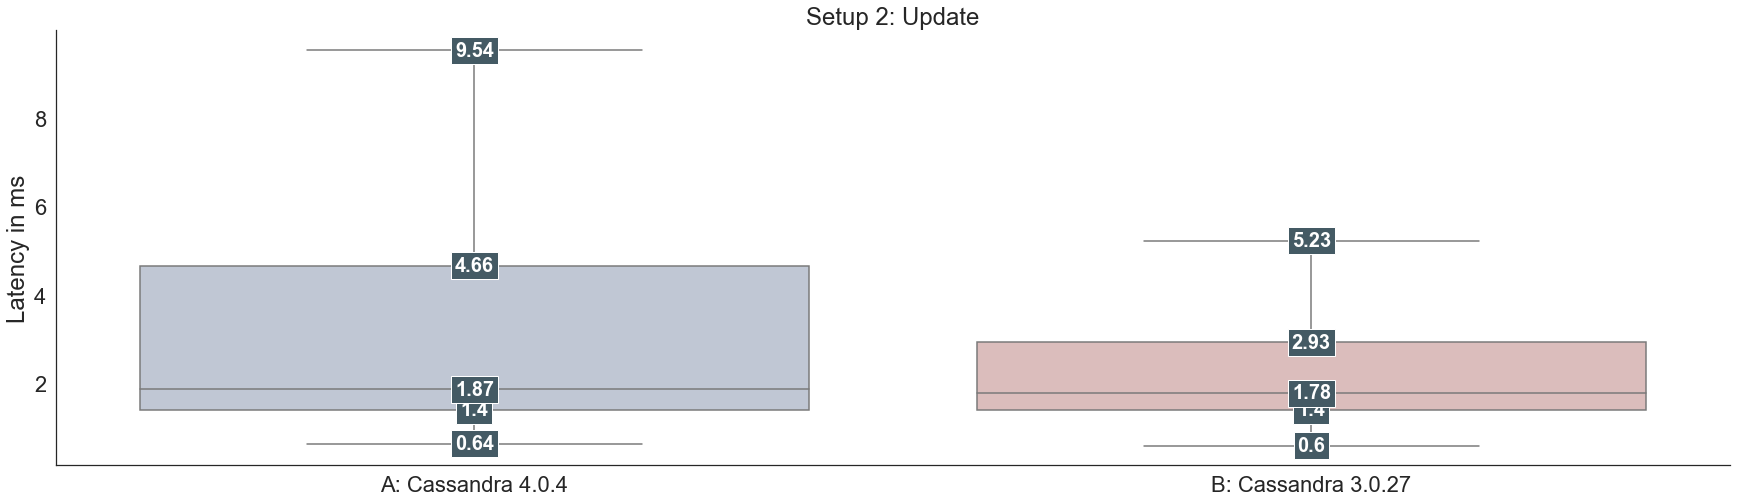

In [493]:
if not setup1: 
    combined_dfs = pd.DataFrame({versionA: dfARead['latency_ms'],
                                 versionB: dfBRead['latency_ms']})

    sns.set_style('white')
    sns.set_context('notebook', font_scale=2.0)

    box_plot = sns.boxplot(data=combined_dfs, color='white', showfliers=False, whis=1.5,palette="vlag").set_title("Setup 2: Update")




    ax = box_plot.axes
    ax.set_ylabel("Latency in ms")
    lines = ax.get_lines()

    categories = ax.get_xticks()

    for i in range(0,5):
        for cat in categories:

            y = round(lines[(i+cat*5)].get_ydata()[0],2) 

            ax.text(
                cat, 
                y, 
                f'{y}', 
                ha='center', 
                va='center', 
                fontweight='bold', 
                size=20,
                color='white',
                bbox=dict(facecolor='#445A64'))


    sns.despine()

In [494]:
sns.set_context("notebook")
sns.set(rc={'figure.figsize':(30,8)})
print(len(df))

2000000


### Create Lineplot comparing latencies of Version A and B

C:\Users\Felix Medicus\AppData\Local\Temp\ipykernel_6552\2917646604.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subchartA["averaged"] = subchartA.latency_ms.rolling(5000).mean().shift(-2500)
C:\Users\Felix Medicus\AppData\Local\Temp\ipykernel_6552\2917646604.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subchartB["averaged"] = subchartB.latency_ms.rolling(5000).mean().shift(-2500)


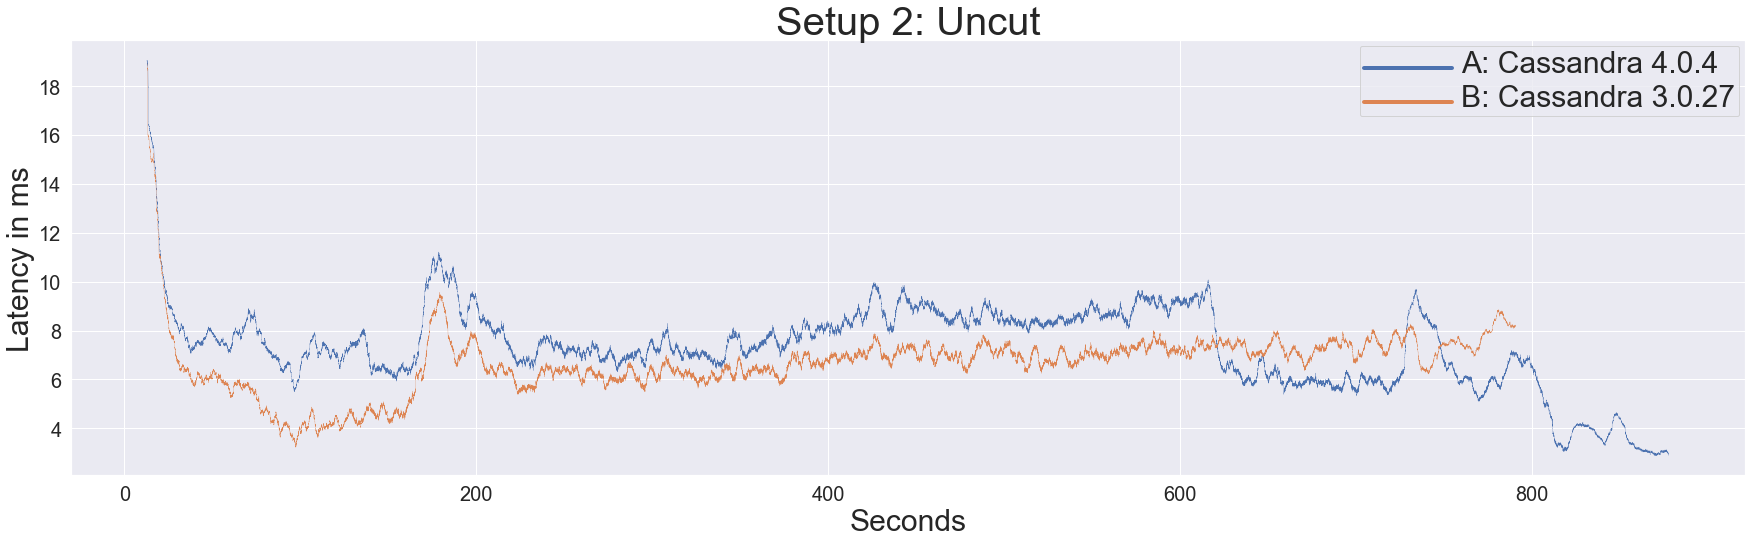

In [495]:

subchartA = (dfARaw[['sent_sec', 'latency_ms']])
subchartB = (dfBRaw[['sent_sec', 'latency_ms']])

subchartA["averaged"] = subchartA.latency_ms.rolling(5000).mean().shift(-2500)
subchartB["averaged"] = subchartB.latency_ms.rolling(5000).mean().shift(-2500)


fig, ax = plt.subplots()

line1 = sns.lineplot(data=subchartA, x="sent_sec", y='averaged', linewidth=.25,label=versionA)

setup = 1 if setup1 else 2

title=f"Setup {setup}: Uncut"

line2 = sns.lineplot(data=subchartB, x='sent_sec',y='averaged', linewidth=.25,label=versionA if aa else versionB).set_title(title)

# Set x and y axis labels
ax.set_xlabel("Seconds");
ax.set_ylabel("Latency in ms");

ax.xaxis.label.set_fontsize(30)
ax.yaxis.label.set_fontsize(30)

for tick in ax.get_xticklabels():
    tick.set_fontsize(20)

for tick in ax.get_yticklabels(): 
    tick.set_fontsize(20)

ax.title.set_fontsize(40)

# get the legend object
leg = ax.legend(handlelength=8)

# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(4.0)


# change font size of every text in the legend
for text in leg.get_texts(): 
    text.set_fontsize(30)


plt.show()

In [496]:
if setup1: 

    subchartA = (dfA[['sent_sec', 'latency_ms']])
    subchartB = (dfB[['sent_sec', 'latency_ms']])

    subchartA["averaged"] = subchartA.latency_ms.rolling(5000).mean().shift(-2500)
    subchartB["averaged"] = subchartB.latency_ms.rolling(5000).mean().shift(-2500)


    fig, ax = plt.subplots()

  
    line1 = sns.lineplot(data=subchartA, x="sent_sec", y='averaged', linewidth=.25,label=versionA)

    line2 = sns.lineplot(data=subchartB, x='sent_sec',y='averaged', linewidth=.25,label=versionA if aa else versionB).set_title("A/B - Reads")

    # Set x and y axis labels
    ax.set_xlabel("Seconds");
    ax.set_ylabel("Latency in ms");

    ax.xaxis.label.set_fontsize(30)
    ax.yaxis.label.set_fontsize(30)

    for tick in ax.get_xticklabels():
        tick.set_fontsize(20)

    for tick in ax.get_yticklabels(): 
        tick.set_fontsize(20)

    ax.title.set_fontsize(40)

    # get the legend object
    leg = ax.legend(handlelength=8)

    # change the line width for the legend
    for line in leg.get_lines():
        line.set_linewidth(4.0)


    # change font size of every text in the legend
    for text in leg.get_texts(): 
        text.set_fontsize(30)


    plt.show()

C:\Users\Felix Medicus\AppData\Local\Temp\ipykernel_6552\609861466.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subchartA["100sec_average"] = subchartA.latency_ms.rolling(5000).mean().shift(-2500)
C:\Users\Felix Medicus\AppData\Local\Temp\ipykernel_6552\609861466.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subchartB["100sec_average"] = subchartB.latency_ms.rolling(5000).mean().shift(-2500)


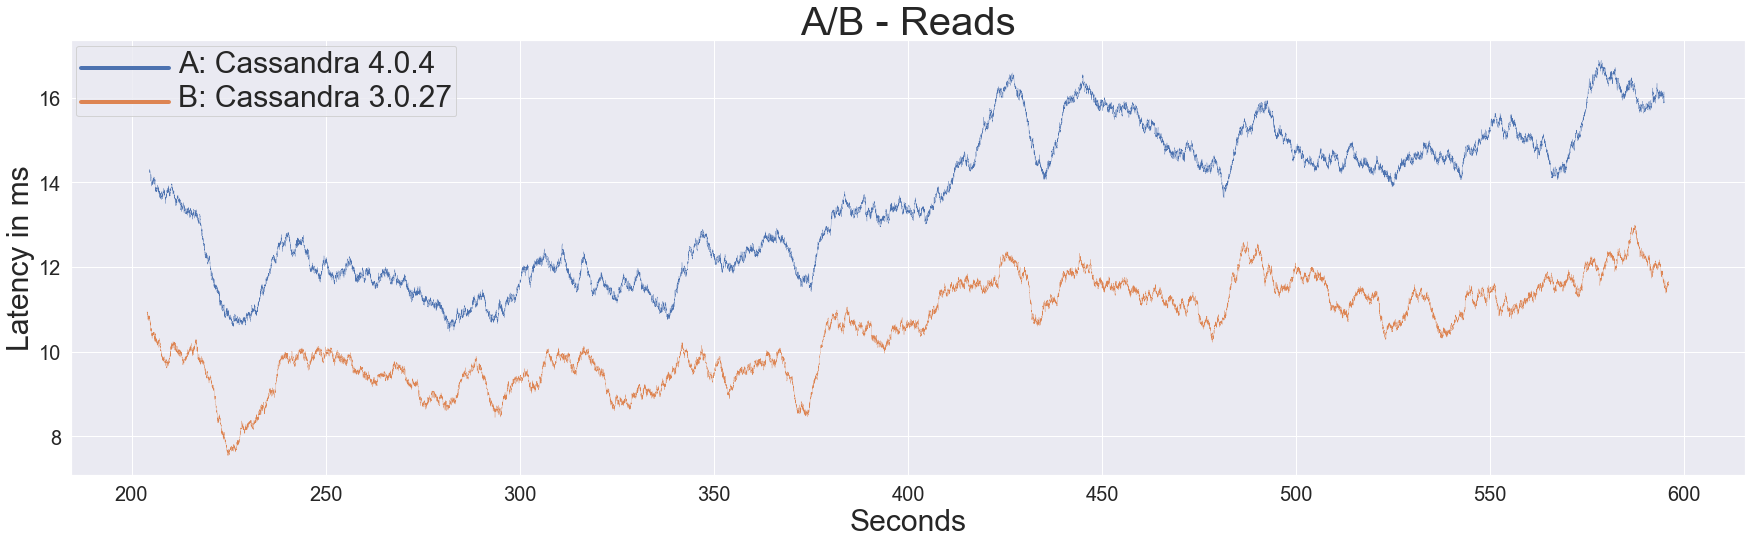

In [497]:
if not setup1: 

    subchartA = dfARead[['sent_sec', 'latency_ms']]
    subchartB = dfBRead[['sent_sec', 'latency_ms']]
    subchartA["100sec_average"] = subchartA.latency_ms.rolling(5000).mean().shift(-2500)
    subchartB["100sec_average"] = subchartB.latency_ms.rolling(5000).mean().shift(-2500)


    fig, ax = plt.subplots()
    title =  "A/B - Reads"
    line1 = sns.lineplot(data=subchartA, x="sent_sec", y="100sec_average", linewidth=0.25, label=versionA)
    line2 = sns.lineplot(data=subchartB, x='sent_sec',y='100sec_average', linewidth=0.25, label=versionA if aa else versionB).set_title(title)


    # Set x and y axis labels
    ax.set_xlabel("Seconds");
    ax.set_ylabel("Latency in ms");

    ax.xaxis.label.set_fontsize(30)
    ax.yaxis.label.set_fontsize(30)

    for tick in ax.get_xticklabels():
        tick.set_fontsize(20)

    for tick in ax.get_yticklabels(): 
        tick.set_fontsize(20)

    ax.title.set_fontsize(40)

    # get the legend object
    leg = ax.legend(handlelength=8)

    # change the line width for the legend
    for line in leg.get_lines():
        line.set_linewidth(4.0)


    # change font size of every text in the legend
    for text in leg.get_texts(): 
        text.set_fontsize(30)


    plt.show()

C:\Users\Felix Medicus\AppData\Local\Temp\ipykernel_6552\375463733.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subchartA["100sec_average"] = subchartA.latency_ms.rolling(5000).mean().shift(-2500)
C:\Users\Felix Medicus\AppData\Local\Temp\ipykernel_6552\375463733.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subchartB["100sec_average"] = subchartB.latency_ms.rolling(5000).mean().shift(-2500)


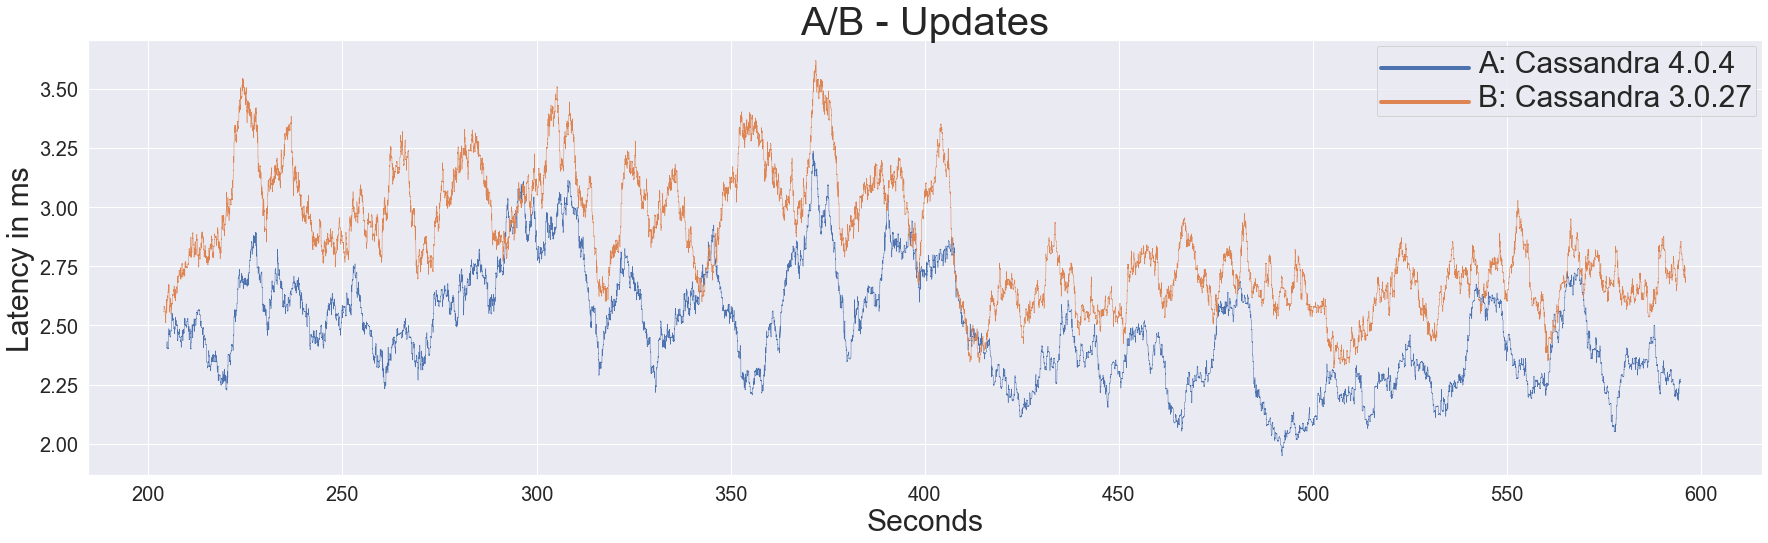

In [498]:
if not setup1: 

    subchartA = dfAUpdate[['sent_sec', 'latency_ms']]
    subchartB = dfBUpdate[['sent_sec', 'latency_ms']]
    subchartA["100sec_average"] = subchartA.latency_ms.rolling(5000).mean().shift(-2500)
    subchartB["100sec_average"] = subchartB.latency_ms.rolling(5000).mean().shift(-2500)


    fig, ax = plt.subplots()
    title =  "A/B - Updates"
    line1 = sns.lineplot(data=subchartA, x="sent_sec", y="100sec_average", linewidth=0.50, label=versionA)
    line2 = sns.lineplot(data=subchartB, x='sent_sec',y='100sec_average', linewidth=0.50, label=versionA if aa else versionB).set_title(title)


    # Set x and y axis labels
    ax.set_xlabel("Seconds");
    ax.set_ylabel("Latency in ms");

    ax.xaxis.label.set_fontsize(30)
    ax.yaxis.label.set_fontsize(30)

    for tick in ax.get_xticklabels():
        tick.set_fontsize(20)

    for tick in ax.get_yticklabels(): 
        tick.set_fontsize(20)

    ax.title.set_fontsize(40)

    # get the legend object
    leg = ax.legend(handlelength=8)

    # change the line width for the legend
    for line in leg.get_lines():
        line.set_linewidth(4.0)


    # change font size of every text in the legend
    for text in leg.get_texts(): 
        text.set_fontsize(30)


    plt.show()

In [499]:
dfAr1Read = dfA1.loc[(dfA1["queryType"] == "SELECT")]
dfAr2Read = dfA2.loc[(dfA2["queryType"] == "SELECT")]
dfAr3Read = dfA3.loc[(dfA3["queryType"] == "SELECT")]
dfBr1Read = dfB1.loc[(dfB1["queryType"] == "SELECT")]
dfBr2Read = dfB2.loc[(dfB2["queryType"] == "SELECT")]
dfBr3Read = dfB3.loc[(dfB3["queryType"] == "SELECT")]
dfAr1Update = dfA1.loc[(dfA1["queryType"] == "UPDATE")]
dfAr2Update = dfA2.loc[(dfA2["queryType"] == "UPDATE")]
dfAr3Update = dfA3.loc[(dfA3["queryType"] == "UPDATE")]
dfBr1Update = dfB1.loc[(dfB1["queryType"] == "UPDATE")]
dfBr2Update = dfB2.loc[(dfB2["queryType"] == "UPDATE")]
dfBr3Update = dfB3.loc[(dfB3["queryType"] == "UPDATE")]